In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

В бібліотеці Keras реалізовані методи для завантаження популярних наборів даних для алгоритмів машинного навчання mnist.load_data() -
повертає два набора даних для навчання і для тестів:

In [6]:
mnist_dataset = tf.keras.datasets.mnist.load_data()
(x_train, y_train), (x_test, y_test) = mnist_dataset
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


Проводимо візуалізацію завантаженого набору даних:

Цифра: 5


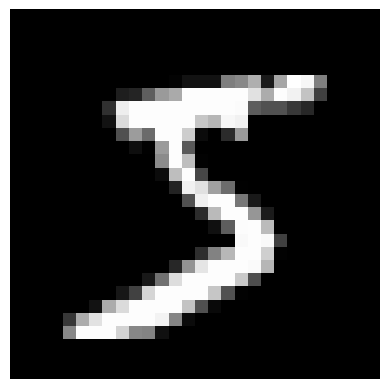

In [26]:
def visualize_dataset_item(x, y):
 print("Цифра:", y)
 plt.imshow(x, cmap=plt.cm.gray)
 plt.axis('off')
item_index = 0
visualize_dataset_item(x_train[item_index], y_train[item_index])

Далі можна побудувати гістограми (діаграми розподілу) за допомогою
функції hist():

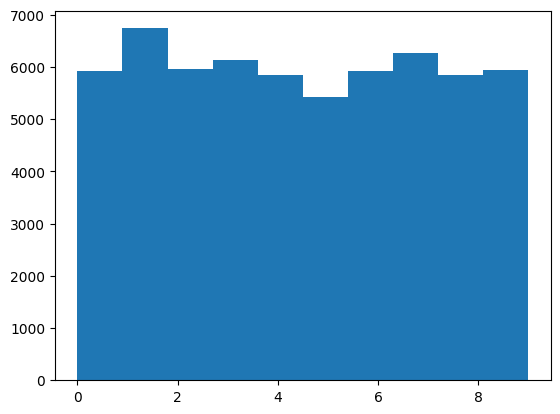

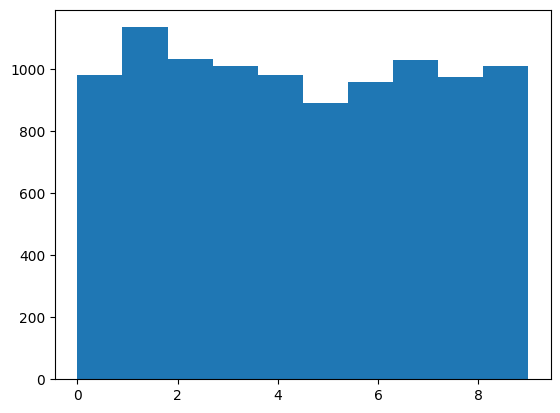

In [8]:
plt.hist(y_train, bins = 10)
plt.show()
plt.hist(y_test, bins = 10)
plt.show()

Проводимо стандартизацію зображень:

In [27]:
def preprocess_image(image):
 image = tf.reshape(image, [28, 28, 1])
 image = tf.image.per_image_standardization(image)
 return image

Перед тим, як почати навчання, потрібно провести попередню обробку
вхідних даних.

In [10]:
total_count = len(y_train)                                              

images_dataset = tf.data.Dataset.from_tensor_slices(x_train)         # створюємо датасет із зображеннями та нормалізуємо їх
images_dataset = images_dataset.map(preprocess_image)

labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)         # приймаємо на вхід масив даних "y_train" та розбиваємо його на окремі елементи, які стають елементами новоствореного датасету

dataset = tf.data.Dataset.zip((images_dataset, labels_dataset))      # об'єднуємо зображення та мітки в один датасет
dataset = dataset.shuffle(buffer_size=1024)                          # перемішуємо 1024 елементів у пам'яті перед кожним новим пакетом

train_dataset = dataset.take(round(total_count * 0.8))               # використовуємо 80% зображень від загальної к-сті для тренування
val_dataset = dataset.skip(round(total_count * 0.8))                 # використовуємо 20% зображень від загальної к-сті для валідаційного набору

train_dataset = train_dataset.batch(128, drop_remainder = False)
train_dataset = train_dataset.prefetch(4)

val_dataset = val_dataset.batch(1, drop_remainder = False)
val_dataset = val_dataset.prefetch(4)

Групування набору шарів у файл (модель нейронної мережі) і
проведення навчання:

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), input_shape=(28, 28, 1), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, (2, 2), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', 
              metrics=['sparse_categorical_accuracy'],)

Обчислюємо значення функції втрат та точності на тренувальному та валідаційному датасетах та зберігаємо історію тренувань. Для навчання мережі використаємо метод fit

In [12]:
history = model.fit(train_dataset, 
                    epochs = 5, 
                    validation_data = val_dataset)

Epoch 1/5
375/375 [==============================] - 51s 134ms/step - loss: 0.1593 - sparse_categorical_accuracy: 0.9524 - val_loss: 0.0717 - val_sparse_categorical_accuracy: 0.9794
Epoch 2/5
375/375 [==============================] - 49s 131ms/step - loss: 0.0439 - sparse_categorical_accuracy: 0.9867 - val_loss: 0.0603 - val_sparse_categorical_accuracy: 0.9818
Epoch 3/5
375/375 [==============================] - 49s 130ms/step - loss: 0.0254 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.0498 - val_sparse_categorical_accuracy: 0.9852
Epoch 4/5
375/375 [==============================] - 49s 131ms/step - loss: 0.0171 - sparse_categorical_accuracy: 0.9946 - val_loss: 0.0479 - val_sparse_categorical_accuracy: 0.9868
Epoch 5/5
375/375 [==============================] - 50s 133ms/step - loss: 0.0122 - sparse_categorical_accuracy: 0.9960 - val_loss: 0.0499 - val_sparse_categorical_accuracy: 0.9882


В коді використано міра помилки – sparse categorical crossentropy, метрика
оптимізації adam (метод адаптивної інерції), який поєднує в собі і ідею накопичення руху
і ідею слабшого поновлення ваги для типових ознак. Можна також використати метод
accuracy. 

Інформацію можна розділтити на 2 види: сигнал та шум.

Сигнал - це частина інформації, з якої можна зробити якісь висновки і яка корисна для моделювання, передбачення та класифікації.
Шум - це частина яка виникає через випадкові зміни в реальному світі. Така інформація не допомагає при моделюванні.
З побудованих кривих навчання можна отримати інформацію про те, що модель врахрвує при навчанні:

Якщо обидві криві (похибка при навчанні та похибка при перевірці) спадають з подальшими ітераціями, модель під час навчання враховує сигнал.
Якщо спадає лише крива похибки при навчанні, це означає, що модель начачається на шумі. Це не призводить до підвищення точності, так як модель занадто сильно "звикає" до даних, на яких тренується. Це явище називається overfitting

проведемо візуалізацію тестового зображення

In [28]:
total_count = len(y_test)

test_images_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_images_dataset = test_images_dataset.map(preprocess_image)

test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)
test_dataset = tf.data.Dataset.zip((test_images_dataset, test_labels_dataset))

test_dataset = test_dataset.batch(128, drop_remainder = False)
test_dataset = test_dataset.prefetch(4)

y_pred = model.predict(test_dataset)

79/79 [==============================] - 11s 141ms/step


Цифра: 7


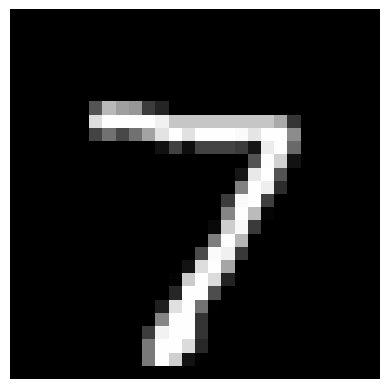

In [35]:
item_index = 0
visualize_dataset_item(x_test[item_index], np.argmax(y_pred[item_index]))

визначимо та візуалізуємо невірно класифікованих зображень під час тестування моделі:

Predicted: 7
Цифра: 2


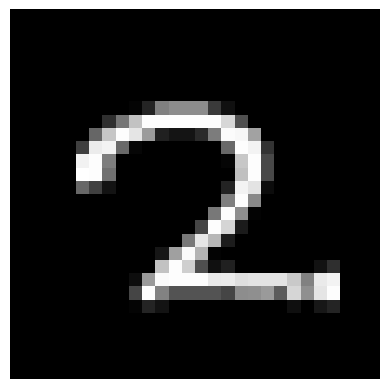

In [50]:
invalid_prediction_indexes = []
for i in range(len(y_test)):
  if np.argmax(y_pred[i]) != y_test[i]:
    invalid_prediction_indexes.append(i)

index = 10

print("Predicted:", np.argmax(y_pred[invalid_prediction_indexes[index]])) 
visualize_dataset_item(x_test[invalid_prediction_indexes[index]], y_test[invalid_prediction_indexes[index]])

оцінимо якість навчання мережі на тестових даних:

In [24]:
print("Test accuracy:", str(100 - round(len(invalid_prediction_indexes) / len(y_pred) * 100, 2)) + "%")

Test accuracy: 82.44%


Побудуємо графік навчання

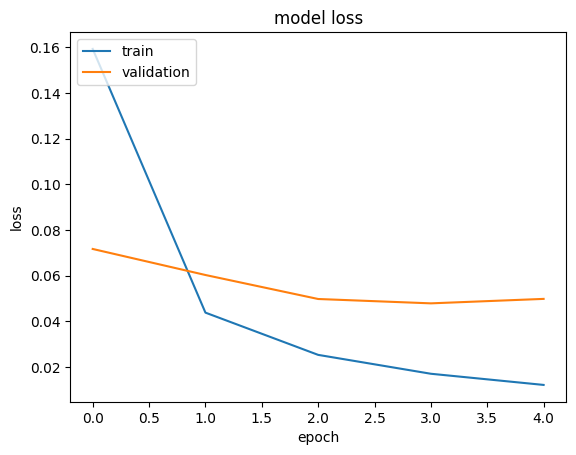

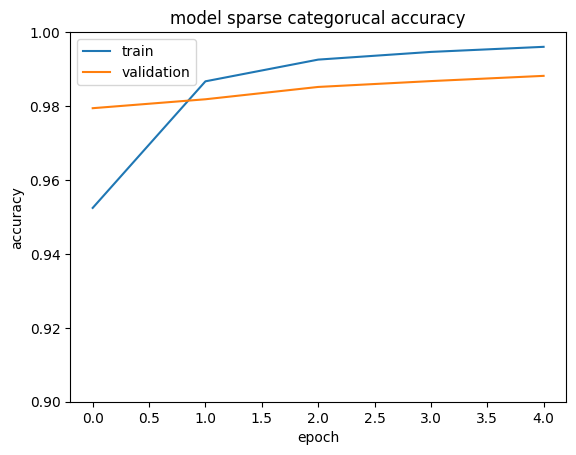

In [51]:
def show_history_charts(histpry):
 plt.plot(history.history['loss'])
 plt.plot(history.history['val_loss'])
 plt.title('model loss')
 plt.ylabel('loss')
 plt.xlabel('epoch')
 plt.legend(['train', 'validation'], loc='upper left')
 plt.show()
 plt.plot(history.history['sparse_categorical_accuracy'])
 plt.plot(history.history['val_sparse_categorical_accuracy'])
 plt.title('model sparse categorucal accuracy')
 plt.ylabel('accuracy')
 plt.xlabel('epoch')
 plt.legend(['train', 'validation'], loc='upper left')
 plt.ylim(0.9, 1)
 plt.show()
show_history_charts(history)

отримані значення свідчать про overfitting. Спробуємо змінити модельдодавши додатковий шар Dropout і змінити кількість ітерацій навчання:

In [52]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', input_shape=(28, 28, 1), activation='relu'),
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, (2, 2), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

history = model.fit(train_dataset, epochs=20, validation_data=val_dataset)


Epoch 1/20
375/375 [==============================] - 245s 652ms/step - loss: 0.2643 - sparse_categorical_accuracy: 0.9162 - val_loss: 0.0581 - val_sparse_categorical_accuracy: 0.9824
Epoch 2/20
375/375 [==============================] - 240s 641ms/step - loss: 0.0778 - sparse_categorical_accuracy: 0.9781 - val_loss: 0.0440 - val_sparse_categorical_accuracy: 0.9882
Epoch 3/20
375/375 [==============================] - 264s 705ms/step - loss: 0.0555 - sparse_categorical_accuracy: 0.9846 - val_loss: 0.0401 - val_sparse_categorical_accuracy: 0.9897
Epoch 4/20
375/375 [==============================] - 236s 630ms/step - loss: 0.0439 - sparse_categorical_accuracy: 0.9881 - val_loss: 0.0346 - val_sparse_categorical_accuracy: 0.9916
Epoch 5/20
375/375 [==============================] - 237s 631ms/step - loss: 0.0379 - sparse_categorical_accuracy: 0.9891 - val_loss: 0.0397 - val_sparse_categorical_accuracy: 0.9908
Epoch 6/20
375/375 [==============================] - 228s 608ms/step - loss: 0.

будуємо новий графік навчання:

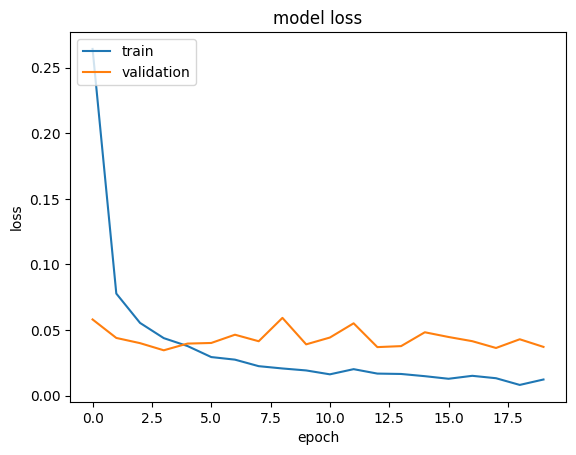

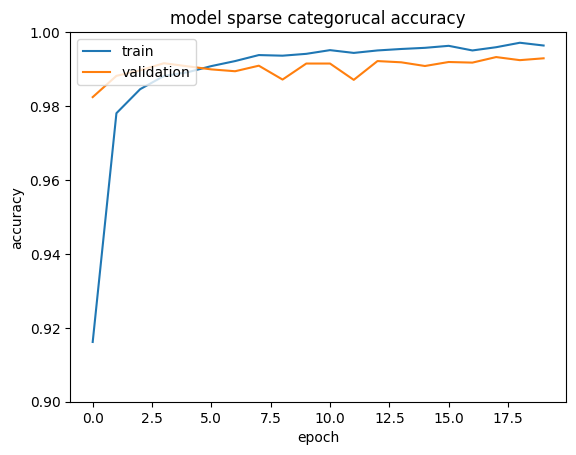

In [54]:
show_history_charts(history)

In [55]:
total_count = len(y_test)

test_images_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_images_dataset = test_images_dataset.map(preprocess_image)

test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)
test_dataset = tf.data.Dataset.zip((test_images_dataset, test_labels_dataset))

test_dataset = test_dataset.batch(128, drop_remainder = False)
test_dataset = test_dataset.prefetch(4)

y_pred = model.predict(test_dataset)

79/79 [==============================] - 10s 121ms/step


проведемо візуалізацію тестового зображення:

Цифра: 4


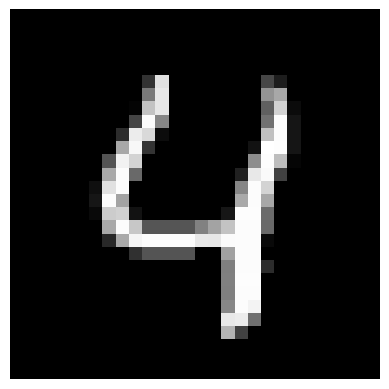

In [59]:
item_index = 4
visualize_dataset_item(x_test[item_index], np.argmax(y_pred[item_index]))

визначимо та візуалізуємо невірно класифікованих зображень під час тестування моделі:

Predicted: 1
Цифра: 7


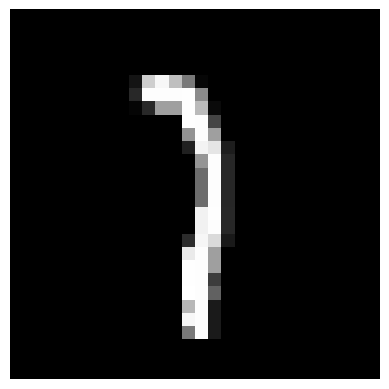

In [60]:
invalid_prediction_indexes = []
for i in range(len(y_test)):
  if np.argmax(y_pred[i]) != y_test[i]:
    invalid_prediction_indexes.append(i)

index = 10

print("Predicted:", np.argmax(y_pred[invalid_prediction_indexes[index]])) 
visualize_dataset_item(x_test[invalid_prediction_indexes[index]], y_test[invalid_prediction_indexes[index]])

оцінимо якість навчання мережі на тестових даних:

In [61]:
print("Test accuracy:", str(100 - round(len(invalid_prediction_indexes) / len(y_pred) * 100, 2)) + "%")

Test accuracy: 99.34%


Завдання 2-3. Провести тестування отриманої моделі на незалежних даних. Зберегти модель нейронної мережі для подальшого її використання.

 збережемо нашу модель на гугл диск:

In [65]:
from google.colab import drive
drive.mount('/content/drive')

model_json_path = "/content/drive/MyDrive/models/model.json"
model_weights_path = "/content/drive/MyDrive/models/model.h5"

# Збереження моделі у JSON-файл
model_json = model.to_json()
with open(model_json_path, "w") as json_file:
    json_file.write(model_json)

# Збереження ваг моделі
model.save_weights(model_weights_path)

Mounted at /content/drive


проведемо тестування на незалежних даних:

In [66]:
from google.colab import files
files.upload()

Saving 7.png to 7.png


{'7.png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xdf\x00\x00\x00\xc8\x08\x06\x00\x00\x00h*4\x0f\x00\x00\x00\tpHYs\x00\x00\x0e\xc4\x00\x00\x0e\xc4\x01\x95+\x0e\x1b\x00\x00\x10dIDATx^\xed\xdd{\x8c\\\xd7A\xc7\xf1\xef9w\xee\xdc\xd9\xb7\xbd\xee\xc6\xeb\xd8.\xa9 8\x844\xa64M\x93*\t)\xa1\x84T\x80*\x8a\x02\x8a\n\rj\x11\x02\x02H\x14Z\x84\x80\x16\x89 \x95 HEU\x01\x11\x08\x85G\x03\x95\x1a*\xa4*RC\x9a\x10\x9a\x07j\xe28E!\x8d\x9a\x84$-v\x8c\x89\xd3\x8d\xbd;s_\x87?f\xeex|<\xdeY\xaf\xd7{fv~\x1fid\xfb\xcc\xd8\xb1\x9d\xfd\xfa\xdc\xc7\xb9\xf7\x1a\xc0!"\x9b\xce\xfa\x03"\xb29\x14\x9fH \x8aO$\x10\xc5\'\x12\x88\xe2\x13\tD\xf1\x89\x04\xa2\xf8D\x02Q|"\x81(>\x91@\x14\x9fH \x8aO$\x10\xc5\'\x12\x88\xe2\x13\tD\xf1\x89\x04\xa2\xf8D\x02Q|"\x81(>\x91@\x14\x9fH \x8aO$\x10\xc5\'\x12\x88\xe2\x13\tD\xf1\x89\x04\xa2\xf8D\x02Q|"\x81(>\x91@\x14\x9fH \x8aO$\x10\xc5\'\x12\x88\xe2\x13\tD\xf1\x89\x04\xa2\xf8D\x02Q|"\x81(>\x91@\x14\x9fH \x8aO$\x10\xc5\'\x12\x88\xe2\x13\tD\xf1\x89\x04\xa2\xf8D\x02Q|"\x81(>\x91@\x14\x9

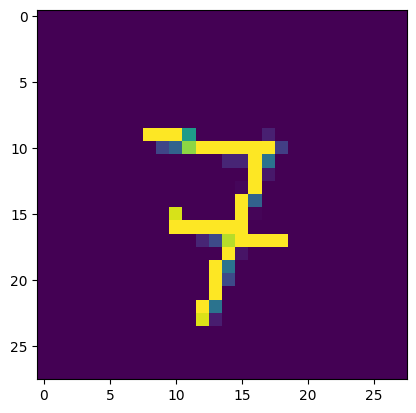

In [78]:
img_path = '7.png' 
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(28, 28))
img = tf.keras.preprocessing.image.img_to_array(img)
img = tf.image.rgb_to_grayscale(img) 
img = tf.reshape(img, [28, 28, 1])      
img = tf.image.per_image_standardization(img) 
plt.imshow(img) 
plt.show()

Загрузимо збережену модель

In [71]:
from tensorflow.keras.models import Sequential, model_from_json 
with open('/content/drive/MyDrive/models/model.json', 'r') as f: 
    loaded_model = model_from_json(f.read()) 
     
loaded_model.load_weights('/content/drive/MyDrive/models/model.h5')

Проведемо розпізнавання картинки

In [79]:
x = tf.keras.utils.img_to_array(img) 
x = x / np.max(x) 
x=np.expand_dims(x,axis=0) 
 
prediction = loaded_model.predict(x) 
classes = ['0','1','2','3','4','5','6','7','8','9'] 
print('Predicted number: ' + classes[np.argmax(prediction)])

1/1 [==============================] - 0s 78ms/step
Predicted number: 7


Загрузимо нове зображення для розпізнання

In [89]:
from google.colab import files
files.upload()

Saving 3.png to 3.png


{'3.png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xdf\x00\x00\x00\xc8\x08\x06\x00\x00\x00h*4\x0f\x00\x00\x00\tpHYs\x00\x00\x0e\xc4\x00\x00\x0e\xc4\x01\x95+\x0e\x1b\x00\x00\x10\xaeIDATx^\xed\xdd{\x8c\\\xd5a\xc7\xf1\xdf}\xcdcgv\xbd\x0f\xaf\xbd6\xb6\xc16$@\x91\r\xb6)\xae\x83e\xa7.\xe4Q%\xa9\xd2\x8aH\r4\r\x08BR%Q*\xb5\xa8\x7f\xd0\xe4\x8f\x86\xaa\xd0\x94J%\x11\x95\x924A\x90\x84\xfca\xa2\xaa\xa9\xc9\xa3\x81\xd085\x94\x871P06\x8eq\xc0\xf6\xfa\xb1k\xef\xee\xec\xce\xdc\xb9\xf7\x9c\xfeq|\xef\xce\xbd;;\x9e\xd9\x9d\x993\x8f\xdfGZ\xe1\xdc\xbb\x08e\xed\xaf\xcf\xb9\xf7\x9c{\xc7\x00 ADMg\xc6\x0f\x10Qs0>"M\x18\x1f\x91&\x8c\x8fH\x13\xc6G\xa4\t\xe3#\xd2\x84\xf1\x11i\xc2\xf8\x884a|D\x9a0>"M\x18\x1f\x91&\x8c\x8fH\x13\xc6G\xa4\t\xe3#\xd2\x84\xf1\x11i\xc2\xf8\x884a|D\x9a0>"M\x18\x1f\x91&\x8c\x8fH\x13\xc6G\xa4\t\xe3#\xd2\x84\xf1\x11i\xc2\xf8\x884a|D\x9a0>"M\x18\x1f\x91&\x8c\x8fH\x13\xc6G\xa4\t\xe3#\xd2\x84\xf1\x11ib\xc7\x0fPk\xe9\xbf\x16Xw\x170\xbc\x13\xe8\xbd\x020\x1a\xf0;&\n\xc0\xf8s&F\x9f4q\xe4!\

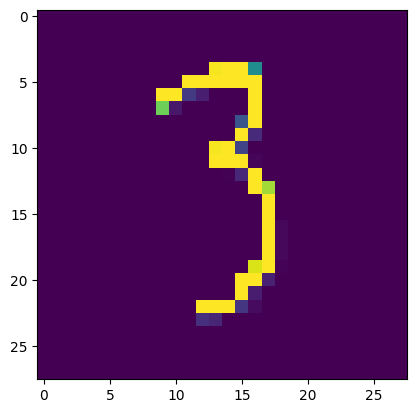

In [90]:
img_path = '3.png' 
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(28, 28))
img = tf.keras.preprocessing.image.img_to_array(img)
img = tf.image.rgb_to_grayscale(img) 
img = tf.reshape(img, [28, 28, 1])      
img = tf.image.per_image_standardization(img) 
plt.imshow(img) 
plt.show()

In [92]:
x = tf.keras.utils.img_to_array(img) 
x = x / np.max(x) 
x=np.expand_dims(x,axis=0) 
 
prediction = loaded_model.predict(x) 
classes = ['0','1','2','3','4','5','6','7','8','9'] 
print('Predicted number: ' + classes[np.argmax(prediction)])

1/1 [==============================] - 0s 22ms/step
Predicted number: 3
